# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
# Mounting drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import tensorflow as tf
#tf.test.gpu_device_name()

''

In [3]:
#pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 33.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.1 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
#Importing required libraries
import numpy as np
import os
from skimage import io
import os
import glob
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import os


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val.csv').readlines())
# Select batch size in such a way that:
# 1. It is in powers of 2
# 2. The batch occupies maximum memory. The idea is to train maximum data that can be fit in memory


In [4]:
#Checking if cropping and resizing is working on sample image
sample_path = os.path.join('/content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train/', train_doc[180].split(';')[0], '*')
sample = glob.glob(sample_path)
sample = io.imread(sample[12])
sample_cropped1 = sample[10:-10,10:-10]
sample_cropped1 = sample_cropped1/255
print(sample_cropped1)
plt.show()

[[[0.68627451 0.70588235 0.69803922]
  [0.69803922 0.71764706 0.71372549]
  [0.71764706 0.7372549  0.72941176]
  ...
  [0.51764706 0.51764706 0.47058824]
  [0.50980392 0.50588235 0.4627451 ]
  [0.50588235 0.50196078 0.45882353]]

 [[0.68627451 0.70588235 0.69803922]
  [0.69411765 0.71372549 0.70588235]
  [0.71764706 0.7372549  0.72941176]
  ...
  [0.51764706 0.51764706 0.47058824]
  [0.51372549 0.50980392 0.46666667]
  [0.50980392 0.50588235 0.4627451 ]]

 [[0.68627451 0.70588235 0.69803922]
  [0.69803922 0.71764706 0.71372549]
  [0.71764706 0.7372549  0.72941176]
  ...
  [0.50588235 0.50196078 0.45882353]
  [0.50588235 0.50196078 0.45098039]
  [0.50588235 0.50196078 0.45882353]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.52156863 0.49411765 0.50196078]
  [0.49019608 0.45882353 0.47058824]
  [0.35686275 0.32941176 0.32941176]]

 [[0.00784314 0.         0.        ]
  [0.00784314 0.         0.        ]


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
#Experimenting on different image index and batch size. Will start with lower batch size and gradually increase according to results.
#img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] #create a list of image numbers you want to use for a particular video
#batch_size = 15

#img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,20,22,24,25,26,27,28] #create a list of image numbers you want to use for a particular video
#batch_size = 21

# hyper params, base settings

batch_size = 32 #experiment with the batch size

# skip images in start and end, use all images in middle
img_idx = [1,3,5,7,9,11,12,13,14,15,16,17,18,19,21,23,25,27,29]



In [7]:
#Generator function which will return each batch with cropped and resized image
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        #astype(np.float32)
        for batch in range(num_batches): # we iterate over the number of batches
            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = image[20:-20,20:-20] #cropping image by chipping off 20 pixels on all sides

                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # resizing the images
                    
                    image_resized=imresize(image, (120,120))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        #remaining_batches = len(train_doc)%batch_size
        remaining_batches =len (folder_list) % batch_size
        for batch in range(remaining_batches): # we iterate over the number of batches
            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((remaining_batches,len(img_idx),120,120,3))
            batch_labels = np.zeros((remaining_batches,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining_batches)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*remaining_batches)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = image[20:-20,20:-20] #cropping image by chipping off 20 pixels on all sides

                    # resizing the images
                    image_resized=imresize(image, (120,120))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*remaining_batches)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
#Setting the train and validation sequence path and checking counts
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train'
val_path = '/content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# Creating a Conv2D Model + RNN

 **Creating a base model: Conv2D + RNN(LSTM)**

In [9]:
#Importing required libraries
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers




In [ ]:
#write your model here

Input_shape= (15, 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'), input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(256, activation='relu'))
#model.add(Dropout (0.5))
model.add(Dense(256, activation='relu'))
#model.add(Dropout (0.5))

model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 60, 60, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 60, 60, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 30, 30, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 30, 30, 32)   9248      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 30, 30, 32)   1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
#saving the models in h5 file
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience=5, verbose=1, min_lr = 0) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:

history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train ; batch size = 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/10
44/45 [============================>.] - ETA: 1:54 - loss: 1.2393 - categorical_accuracy: 0.4955

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


45/45 [==============================] - ETA: 0s - loss: 1.2273 - categorical_accuracy: 0.5007  Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val ; batch size = 15

Epoch 1: saving model to model_init_2022-02-2413_28_58.574848/model-00001-1.22728-0.50074-2.18174-0.15238.h5
45/45 [==============================] - 5649s 128s/step - loss: 1.2273 - categorical_accuracy: 0.5007 - val_loss: 2.1817 - val_categorical_accuracy: 0.1524 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 0.8286 - categorical_accuracy: 0.6815
Epoch 2: saving model to model_init_2022-02-2413_28_58.574848/model-00002-0.82864-0.68148-3.19133-0.14286.h5
45/45 [==============================] - 149s 3s/step - loss: 0.8286 - categorical_accuracy: 0.6815 - val_loss: 3.1913 - val_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.5700 - categorical_accuracy: 0.7941
Epoch 3

Model is clearly overfitting. Now let us add dropouts and see if it improves validation accuracy. Also let us increase number of epochs and see if there is any change in the result

**Conv2D + RNN(LSTM) + Model with dropout + more epochs**

In [ ]:
Input_shape= (15, 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'), input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))


model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))


model.add(TimeDistributed(Flatten()))

model.add(Dense(256, activation='relu'))
model.add(Dropout (0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout (0.25))

model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 60, 60, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 60, 60, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 dropout (Dropout)           (None, 15, 30, 30, 32)    0         
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 30, 30, 32)   9248      
 stributed)                                           

In [ ]:
num_epochs=20
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/20
16/45 [=========>....................] - ETA: 40s - loss: 1.6316 - categorical_accuracy: 0.2958

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


45/45 [==============================] - ETA: 0s - loss: 1.4324 - categorical_accuracy: 0.3896
Epoch 1: saving model to model_init_2022-02-2413_28_58.574848/model-00001-1.43239-0.38963-3.03339-0.20000.h5
45/45 [==============================] - 77s 2s/step - loss: 1.4324 - categorical_accuracy: 0.3896 - val_loss: 3.0334 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.9269 - categorical_accuracy: 0.6548
Epoch 2: saving model to model_init_2022-02-2413_28_58.574848/model-00002-0.92694-0.65481-2.65007-0.26667.h5
45/45 [==============================] - 75s 2s/step - loss: 0.9269 - categorical_accuracy: 0.6548 - val_loss: 2.6501 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.7083 - categorical_accuracy: 0.7274
Epoch 3: saving model to model_init_2022-02-2413_28_58.574848/model-00003-0.70828-0.72741-3.08921-0.19048.h5
45/45 [===========================

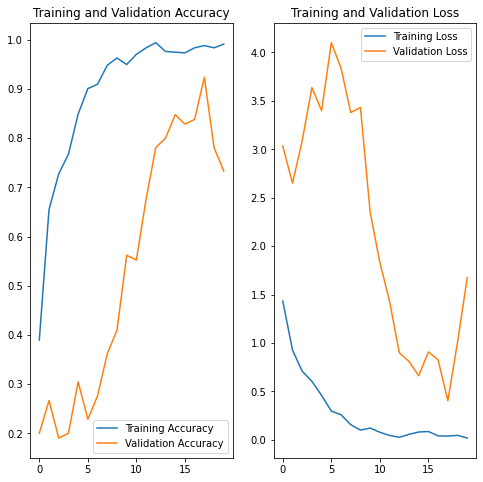

In [ ]:
#Plotting the stats for Training and Validation data
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The accuracy has increased but it is still on lower side. Let's add more images in image index and also increase batch size and epochs

In [ ]:

#img_idx = [0,2,4,6,8,10,11,12,13,14,15,16,17,18,20,22,24,25,26,27,28] #create a list of image numbers you want to use for a particular video
#batch_size = 30

In [27]:
Input_shape= (len(img_idx), 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'), input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

#model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
#model.add(Dropout (0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(256, activation='relu'))
model.add(Dropout (0.25))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout (0.25))

model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(5, activation='softmax'))

In [28]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_23 (TimeDi  (None, 19, 60, 60, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 19, 60, 60, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 19, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 dropout_10 (Dropout)        (None, 19, 30, 30, 32)    0         
                                                                 
 time_distributed_26 (TimeDi  (None, 19, 30, 30, 64)   18496     
 stributed)                                           

In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience=5, verbose=1, min_lr = 0) # write the REducelronplateau code here


# if loss doesn't decrease for 10 epocs, stop training 
ES = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

callbacks_list = [checkpoint, LR, ES]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
num_epochs=50
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train ; batch size = 32
Epoch 1/50
19/21 [==========================>...] - ETA: 7s - loss: 1.5396 - categorical_accuracy: 0.3470 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - ETA: 0s - loss: 1.5051 - categorical_accuracy: 0.3695Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-0109_35_41.581190/model-00001-1.50509-0.36953-1.81242-0.32000.h5
21/21 [==============================] - 91s 4s/step - loss: 1.5051 - categorical_accuracy: 0.3695 - val_loss: 1.8124 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1220 - categorical_accuracy: 0.5507
Epoch 2: saving model to model_init_2022-03-0109_35_41.581190/model-00002-1.12202-0.55072-3.43662-0.18056.h5
21/21 [==============================] - 66s 3s/step - loss: 1.1220 - categorical_accuracy: 0.5507 - val_loss: 3.4366 - val_categorical_accuracy: 0.1806 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.8770 - categorical_accuracy: 0.6591
Epoch 3: savin

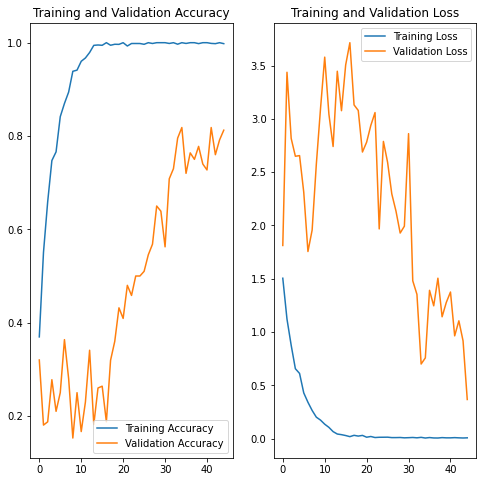

In [33]:
#Plotting stats for Training and Validation
acc = history1.history['categorical_accuracy']
val_acc = history1.history['val_categorical_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(45)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is significant improvement in accuracy. The best model has accuracy of around 87%

Let's see how GRU model is performing for the same parameters

**Conv2D + RNN (GRU)**

In [10]:
Input_shape= (len(img_idx), 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2,2), activation='relu', padding='same'), input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(256, activation='relu'))
model.add(Dropout (0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout (0.25))

model.add(GRU(512, return_sequences=False, dropout=0.50)) # Trying out GRU model
model.add(Dense(5, activation='softmax'))

In [11]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 19, 60, 60, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 19, 60, 60, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 19, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 19, 30, 30, 16)    0         
                                                                 
 time_distributed_3 (TimeDis  (None, 19, 30, 30, 32)   4640      
 tributed)                                              

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience=5, verbose=1, min_lr = 0) # write the REducelronplateau code here


# if loss doesn't decrease for 10 epocs, stop training 
ES = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

callbacks_list = [checkpoint, LR, ES]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
#num_epochs=50
history12 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/50
19/21 [==========================>...] - ETA: 8:18 - loss: 1.6920 - categorical_accuracy: 0.3109 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - ETA: 0s - loss: 1.6498 - categorical_accuracy: 0.3258  Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-0109_35_41.581190/model-00001-1.64977-0.32579-1.68990-0.19000.h5
21/21 [==============================] - 5533s 276s/step - loss: 1.6498 - categorical_accuracy: 0.3258 - val_loss: 1.6899 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1936 - categorical_accuracy: 0.5342
Epoch 2: saving model to model_init_2022-03-0109_35_41.581190/model-00002-1.19365-0.53416-2.53177-0.22222.h5
21/21 [==============================] - 98s 5s/step - loss: 1.1936 - categorical_accuracy: 0.5342 - val_loss: 2.5318 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.0018 - categorical_accuracy: 0.6244 
Epoch 3

In [17]:
#Plotting stats for Training and Validation
acc = history12.history['categorical_accuracy']
val_acc = history12.history['val_categorical_accuracy']

loss = history12.history['loss']
val_loss = history12.history['val_loss']

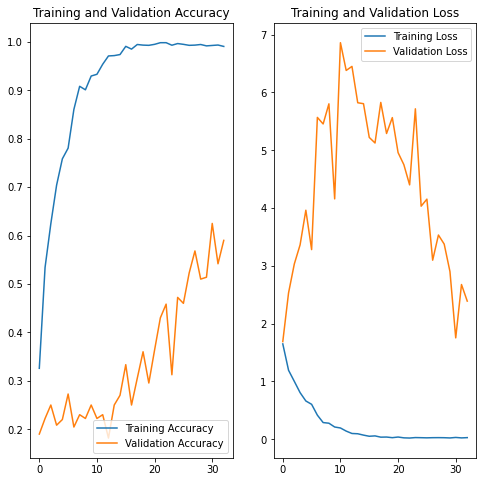

In [18]:
epochs_range =  range(33)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model stopped early because of no significant drop in validation loss. Also the model is overfitting. The trainable parameters are very high in this model. Let's decrease the trainable parameters and see if it improves the GRU model performance

In [19]:
Input_shape= (len(img_idx), 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'), input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
model.add(Dropout (0.25))

#model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
#model.add(Dropout (0.25))

model.add(TimeDistributed(Flatten()))

model.add(Dense(256, activation='relu'))
model.add(Dropout (0.25))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout (0.25))

model.add(GRU(256, return_sequences=False, dropout=0.25)) # Trying out GRU model
model.add(Dense(5, activation='softmax'))


In [20]:
optimiser = 'adam'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 19, 60, 60, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 19, 60, 60, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 19, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 dropout_6 (Dropout)         (None, 19, 30, 30, 32)    0         
                                                                 
 time_distributed_16 (TimeDi  (None, 19, 30, 30, 64)   18496     
 stributed)                                           

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience=5, verbose=1, min_lr = 0) # write the REducelronplateau code here


# if loss doesn't decrease for 10 epocs, stop training 
ES = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

callbacks_list = [checkpoint, LR, ES]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
#num_epochs=50
history13 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/50
19/21 [==========================>...] - ETA: 6s - loss: 1.8535 - categorical_accuracy: 0.2977 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


21/21 [==============================] - ETA: 0s - loss: 1.7950 - categorical_accuracy: 0.3213Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2022-03-0109_35_41.581190/model-00001-1.79503-0.32127-1.99167-0.28000.h5
21/21 [==============================] - 89s 4s/step - loss: 1.7950 - categorical_accuracy: 0.3213 - val_loss: 1.9917 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2080 - categorical_accuracy: 0.5010
Epoch 2: saving model to model_init_2022-03-0109_35_41.581190/model-00002-1.20804-0.50104-2.49399-0.23611.h5
21/21 [==============================] - 65s 3s/step - loss: 1.2080 - categorical_accuracy: 0.5010 - val_loss: 2.4940 - val_categorical_accuracy: 0.2361 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9642 - categorical_accuracy: 0.6380
Epoch 3: savin

In [25]:
#Plotting stats for Training and Validation
acc = history13.history['categorical_accuracy']
val_acc = history13.history['val_categorical_accuracy']

loss = history13.history['loss']
val_loss = history13.history['val_loss']

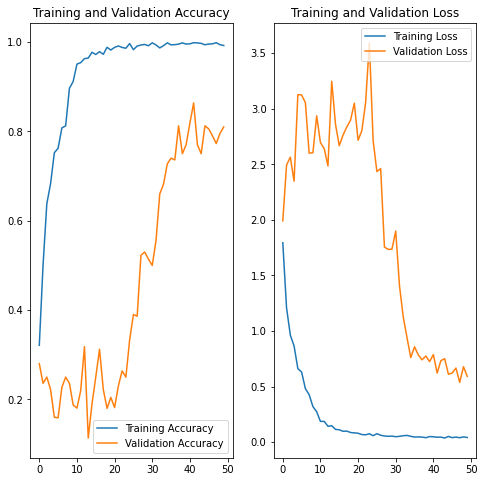

In [26]:
epochs_range =  range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is significant improvement after we simplified the model. The best model has accuracy of around 87%

In [ ]:
# Creaitng a Conv3D Model

**Conv3D model**

In [ ]:
img_height = 120
img_width = 120
number_of_images = len(img_idx)
num_classes = 5
batch_size=30

Input_shape= (len(img_idx), 120, 120, 3)

model_conv3D = Sequential()

model_conv3D.add(Conv3D(32, kernel_size=(2,2,2), activation='relu', kernel_initializer='he_uniform', input_shape=Input_shape))
model_conv3D.add(BatchNormalization())
model_conv3D.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model_conv3D.add(Conv3D(64, kernel_size=(2,2,2), activation='relu', kernel_initializer='he_uniform'))
model_conv3D.add(BatchNormalization())
model_conv3D.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model_conv3D.add(Flatten())
model_conv3D.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_conv3D.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimiser = 'adam'#write your optimizer
model_conv3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3D.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 119, 119, 32)  800       
                                                                 
 batch_normalization_4 (Batc  (None, 18, 119, 119, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 58, 58, 64)     16448     
                                                                 
 batch_normalization_5 (Batc  (None, 8, 58, 58, 64)    256       
 hNormalization)                                                 
                                                      

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience=5, verbose=1, min_lr = 0) # write the REducelronplateau code here

# if loss doesn't decrease for 10 epocs, stop training 
ES = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

callbacks_list = [checkpoint, LR, ES]

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [ ]:
num_epochs=50
history5 = model_conv3D.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train ; batch size = 30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/50
21/23 [==========================>...] - ETA: 4:41 - loss: 42.1515 - categorical_accuracy: 0.4667

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


23/23 [==============================] - ETA: 0s - loss: 40.5974 - categorical_accuracy: 0.4766  Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-02-2818_32_24.589103/model-00001-40.59737-0.47662-26.83780-0.31000.h5
23/23 [==============================] - 3398s 154s/step - loss: 40.5974 - categorical_accuracy: 0.4766 - val_loss: 26.8378 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 2.7408 - categorical_accuracy: 0.7673
Epoch 2: saving model to model_init_2022-02-2818_32_24.589103/model-00002-2.74082-0.76730-20.38695-0.35000.h5
23/23 [==============================] - 91s 4s/step - loss: 2.7408 - categorical_accuracy: 0.7673 - val_loss: 20.3870 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.0336 - categorical_accuracy: 0.7915
E

In [ ]:
acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

NameError: ignored

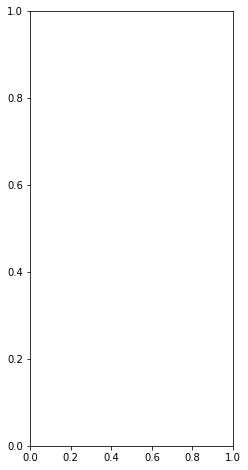

In [ ]:
epochs_range =  range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Now including drpouts in Conv3D Model

In [ ]:
img_height = 120
img_width = 120
number_of_images = len(img_idx)
num_classes = 5
batch_size=30

Input_shape= (len(img_idx), 120, 120, 3)

model_conv3D_dropouts = Sequential()

model_conv3D_dropouts.add(Conv3D(32, kernel_size=(2,2,2), activation='relu', kernel_initializer='he_uniform', input_shape=Input_shape))
model_conv3D_dropouts.add(BatchNormalization())
model_conv3D_dropouts.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model_conv3D_dropouts.add(Dropout(0.25))

model_conv3D_dropouts.add(Conv3D(64, kernel_size=(2,2,2), activation='relu', kernel_initializer='he_uniform'))
model_conv3D_dropouts.add(BatchNormalization())
model_conv3D_dropouts.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))
model_conv3D_dropouts.add(Dropout(0.25))

model_conv3D_dropouts.add(Flatten())
model_conv3D_dropouts.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_conv3D_dropouts.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimiser = 'adam'#write your optimizer
model_conv3D_dropouts.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3D_dropouts.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 119, 119, 32)  800       
                                                                 
 batch_normalization_4 (Batc  (None, 20, 119, 119, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 59, 59, 32)   0         
 )                                                               
                                                                 
 dropout_6 (Dropout)         (None, 10, 59, 59, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 58, 58, 64)     16448     
                                                                 
 batch_normalization_5 (Batc  (None, 9, 58, 58, 64)   

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience=5, verbose=1, min_lr = 0) # write the REducelronplateau code here

# if loss doesn't decrease for 10 epocs, stop training 
ES = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

callbacks_list = [checkpoint, LR, ES]

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


In [ ]:
num_epochs=50
history6 = model_conv3D_dropouts.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/train ; batch size = 30
Epoch 1/50
21/23 [==========================>...] - ETA: 5s - loss: 86.3165 - categorical_accuracy: 0.3540

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


23/23 [==============================] - ETA: 0s - loss: 80.0688 - categorical_accuracy: 0.3681Source path =  /content/drive/MyDrive/AIML/ColabNotebooks/RNN/RNNAssignmentGestureRecognition/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-02-2804_52_07.394475/model-00001-80.06879-0.36812-49.87498-0.22500.h5
23/23 [==============================] - 84s 4s/step - loss: 80.0688 - categorical_accuracy: 0.3681 - val_loss: 49.8750 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 7.0730 - categorical_accuracy: 0.6971
Epoch 2: saving model to model_init_2022-02-2804_52_07.394475/model-00002-7.07300-0.69710-41.92321-0.26667.h5
23/23 [==============================] - 83s 4s/step - loss: 7.0730 - categorical_accuracy: 0.6971 - val_loss: 41.9232 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.5499 - categorical_accuracy: 0.8536
Epoch 3

In [ ]:
acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

In [ ]:
epochs_range =  range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()